# Temporal Fusion Transformer (TFT)

This notebook covers the impementation of a TFT model for load forecasting purposes.

The model is implemented using the Darts python package

Please pip install the requirements.txt file before running

Authors: Ali Kamran, (Andreas Liiv, Florian Kühn)

In [ ]:
# Import required modules
from darts.explainability.tft_explainer import TFTExplainer
import seaborn as sns
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback
from optuna.exceptions import TrialPruned
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import warnings  # Suppress warnings for cleaner output
import os  # Operating system interface
import optuna  # Hyperparameter optimization
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation
import torch  # PyTorch for deep learning
from darts.utils.likelihood_models.base import LikelihoodType  # Darts likelihood types
from darts.metrics import mape, rmse, mse, mae, r2_score, smape  # Darts metrics
from darts import TimeSeries  # Darts TimeSeries object
from darts.dataprocessing.transformers import Scaler  # Data scaling
from darts.metrics import mape  # Mean Absolute Percentage Error
import holidays  # Holiday calculations
import torchmetrics  # PyTorch metrics
from torchmetrics.collections import MetricCollection  # Metric collection
from darts.models import TFTModel  # Temporal Fusion Transformer model
# Quantile regression for probabilistic forecasting
from darts.utils.likelihood_models import QuantileRegression
import torch.optim as optim  # PyTorch optimizers

# Set matrix multiplication precision
torch.set_float32_matmul_precision('medium')
device0 = torch.device("cuda" if torch.cuda.is_available()
                       else "cpu")  # Set device
# warnings.filterwarnings("ignore")  # Ignore warnings
print(torch.cuda.is_available())

True


In [ ]:
def read_load_data():
    '''
    Reads load data from file 'processed_loadUTC_data.csv'.
    Renames columns for better handling in future code.

    Returns: DataFrame containing load data
    '''

    base_dir = os.getcwd()
    load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
    load_data = pd.read_csv(load_file_path)
    load_data.rename(columns={
        "Actual Total Load [MW] - BZN|SE4": "Actual Load",
        "Time (UTC)": "Time"
    }, inplace=True)
    load_data['Time'] = pd.to_datetime(
        load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    load_data.set_index('Time', inplace=True)
    load_data.drop(
        'Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
    return load_data


data = read_load_data()

In [ ]:
def import_weather_data(df, solar_power=False):
    '''
    The weighted averages of weather data (incl. temperature, humidity and solar irradiation) is read and added to the main dataframe.
    If "solar_power" is given as 'True', solar irradiation data is replaced by an estimate of total solar power generation.

    Parameters:
        df: pandas DataFrame
        solar_power: boolean for converting solar irradiation to solar power if 'True'

    Returns: input DataFrame appended with weather data
    '''

    base_dir = os.getcwd()
    temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
    humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
    solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
    avg_temperature_data = pd.read_csv(temperature_file_path)
    avg_humidity_data = pd.read_csv(humidity_file_path)
    avg_solar_data = pd.read_csv(solar_file_path)
    df['Temperature'] = avg_temperature_data['weighted_avg'].values
    df['Humidity'] = avg_humidity_data['weighted_avg'].values
    df['Solar_Irrad'] = avg_solar_data['weighted_avg'].values

    if solar_power:
        tot_installed_capacity = np.array([
            2.52, 5.04, 7.56, 10.08, 12.6, 18.6, 29.2, 41.53, 69.55, 85
        ]) * 1e6
        installed_capacity_house = 10 * 1e3
        n_installations = tot_installed_capacity / installed_capacity_house
        panel_per_house = 24
        area_per_panel = 2

        years = np.arange(2015, 2025)
        total_area_panels = n_installations * panel_per_house * area_per_panel
        area_by_year = dict(zip(years, total_area_panels))

        panel_efficiency = 0.2
        df['year'] = df.index.year
        df['Solar'] = df['Solar_Irrad'] * \
            df['year'].map(area_by_year) * panel_efficiency
        df.drop(columns='year', inplace=True)
    else:
        df['Solar'] = df['Solar_Irrad']
    df.drop(columns='Solar_Irrad', inplace=True)
    return df


data = import_weather_data(data, solar_power=True)

In [ ]:
def import_swedish_holidays(df):
    '''
    Imports Swedish holidays into column 'is_holiday' of input DataFrame

    Parameters:
        df: pandas Dataframe

    Returns: DataFrame appended with Swedish holidays
    '''
    years = np.arange(2015, 2025)
    raw_holidays = []
    for date, name in sorted(holidays.Sweden(years=years).items()):
        if name != "Söndag":
            raw_holidays.append(date)
        raw_holidays.append(date)
    holiday_dates = set(raw_holidays)
    df['is_holiday'] = pd.Series(df.index.date).isin(
        holiday_dates).astype(int).values
    return df


data = import_swedish_holidays(data)

In [ ]:
def create_date_features(df):
    '''
    Creates date features marking the hour of the day

    Parameters:
        df: pandas DataFrame

    Returns: DataFrame appended with hour
    '''
    df['hour'] = df.index.hour
    return df


data = create_date_features(data)

In [ ]:
def add_noise_to_covariates(df, noise_level=0.05):
    """
    Adds Gaussian noise to weather-related covariates ('Temperature', 'Humidity', 'Solar').

    The function adds random noise with a standard deviation proportional to the value
    (for 'Solar') or to the column's standard deviation (for 'Temperature' and 'Humidity').
    This is useful for simulating measurement uncertainty or for data augmentation.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing weather covariates.
    noise_level : float, optional
        Standard deviation of the Gaussian noise as a fraction of the value (default is 0.05).

    Returns
    -------
    pandas.DataFrame
        DataFrame with noisy weather covariates.
    """
    np.random.seed(42)  # Set random seed for reproducibility
    stochastic_cols = ["Temperature", "Humidity", "Solar"]
    df_noisy = df.copy()
    for col in stochastic_cols:
        if col in df_noisy.columns:
            if col == "Solar":
                base = df_noisy[col].values
                noise = np.random.normal(0, noise_level * base)
                df_noisy[col] += noise
                df_noisy[col] = df_noisy[col].clip(lower=0)
            else:
                std = df_noisy[col].std()
                noise = np.random.normal(
                    0, noise_level * std, size=len(df_noisy))
                df_noisy[col] += noise
    return df_noisy


# Retain the original data without noise
clean_future_data = data.copy()
future_data = add_noise_to_covariates(data)

In [ ]:
def create_lag_features(df, load="Actual Load", nan=False):
    '''
    Creates lagged covariate and load features. Can fill target value (load) lags with NaNs if nan is 'True'.

    df: pandas DataFrame
    nan: fills all load lags with NaNs if 'True'
    '''

    df = df.copy()
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'lag_temp_{lag}'] = df["Temperature"].shift(lag)
        df[f'lag_humid_{lag}'] = df["Humidity"].shift(lag)
        df[f'lag_solar_{lag}'] = df["Solar"].shift(lag)
        if lag <= 3:
            df[f'lag_hour_{lag}'] = df["hour"].shift(lag)
        if nan:
            df[f'lag_{lag}'] = np.nan
        else:
            df[f'lag_{lag}'] = df[load].shift(lag)
    for day in range(2, 8):
        lag = day * 24
        if nan:
            df[f'lag_{lag}'] = np.nan
        else:
            df[f'lag_{lag}'] = df[load].shift(lag)
    return df


data = create_lag_features(data)
data = data.dropna()  # first week in 2015 dropped to enable lag features
print(data.columns.tolist())
# droping the lagged features not used in the model
data.drop(
    columns=[
        'lag_1',
        'lag_2',
        'lag_3',
        'lag_6',
        'lag_12',
        'lag_hour_1',
        'lag_hour_2',
        'lag_hour_1',
        'lag_hour_3',
    ],
    inplace=True)
# future_data = create_lag_features(future_data, nan=True)
future_data = future_data[future_data.index >= data.index.min()]

['Actual Load', 'Temperature', 'Humidity', 'Solar', 'is_holiday', 'hour', 'lag_temp_1', 'lag_humid_1', 'lag_solar_1', 'lag_hour_1', 'lag_1', 'lag_temp_2', 'lag_humid_2', 'lag_solar_2', 'lag_hour_2', 'lag_2', 'lag_temp_3', 'lag_humid_3', 'lag_solar_3', 'lag_hour_3', 'lag_3', 'lag_temp_6', 'lag_humid_6', 'lag_solar_6', 'lag_6', 'lag_temp_12', 'lag_humid_12', 'lag_solar_12', 'lag_12', 'lag_temp_24', 'lag_humid_24', 'lag_solar_24', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168']


In [ ]:
# drop all the data before 2022
data = data[data.index >= "2022-01-01"]

future_data = future_data[future_data.index >= "2022-01-01"]
clean_future_data = clean_future_data[clean_future_data.index >= "2022-01-01"]
# print(future_data.index)  # Should be DatetimeIndex

series = TimeSeries.from_dataframe(data, value_cols="Actual Load")
# print(series.columns.tolist())   # Lists all column names

In [ ]:
# Split dates for training and validation sets
training_cutoff = pd.Timestamp("2023-12-31 23:00:00")
train_cov_cutoff = pd.Timestamp("2024-01-01 00:00:00")
validating_cutoff = pd.Timestamp("2024-06-30 23:00:00")

In [ ]:
# Split after training_cutoff
train, rest = series.split_after(training_cutoff)

# Split the remaining data after validating_cutoff
val, test = rest.split_after(validating_cutoff)
print('Train Series:', train.start_time(), train.end_time())
print('Val Series:', val.start_time(), val.end_time())
print('Test Series:', test.start_time(), test.end_time())

# Normalize the time series (scaling)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)
test_transformed = transformer.transform(test)

Train Series: 2022-01-01 00:00:00 2023-12-31 23:00:00
Val Series: 2024-01-01 00:00:00 2024-06-30 23:00:00
Test Series: 2024-07-01 00:00:00 2024-12-31 23:00:00


In [ ]:
# Select all columns except 'Actual Load'
value_cols = [col for col in data.columns if col != "Actual Load"]

# Create the TimeSeries (assuming index is datetime or time_col is defined)
past_covariates = TimeSeries.from_dataframe(data, value_cols=value_cols)
# Normalize historical covariates
scaler_covs = Scaler()
scaler_covs.fit(past_covariates[:training_cutoff])
past_covariates_transformed = scaler_covs.transform(past_covariates)
# Use same cutoff points for consistency
train_past_covs, rest_past_covs = past_covariates_transformed.split_after(
    training_cutoff)
val_past_covs, test_past_covs = rest_past_covs.split_after(validating_cutoff)
last24_ = train_past_covs[-24:]
val_past_covs = last24_.append(val_past_covs)

In [ ]:
# Apply the same approach for future covariates:
# Right now we are using the same data as past covariates

# Drop "Actual Load" from value columns
value_cols = [col for col in future_data.columns if col != "Actual Load"]

# Create the TimeSeries
future_covariates = TimeSeries.from_dataframe(
    future_data, value_cols=value_cols)
clean_future_cov = TimeSeries.from_dataframe(
    clean_future_data, value_cols=value_cols)
# Clean future covariates for training as its not intended the model to
# learn the noise pattern otherwise it performs better
clean_train_future_covs, rest_future_covs = clean_future_cov.split_after(
    training_cutoff)
noisy_data, rest_data = future_covariates.split_after(training_cutoff)
print(clean_train_future_covs.end_time())
print(rest_data.start_time())
future_covariates = clean_train_future_covs.append(rest_data)

# Apply the same approach for future covariates:
scaler_covs_future = Scaler()
# Fit on training data
scaler_covs_future.fit(future_covariates[:training_cutoff])

# Transform all future covariates
future_covariates_transformed = scaler_covs_future.transform(future_covariates)

# Split transformed future covariates into training, validation, and test sets
train_future_covs, rest_future_covs = future_covariates_transformed.split_after(
    training_cutoff)
val_future_covs, test_future_covs = rest_future_covs.split_after(
    validating_cutoff)

last24_ = train_future_covs[-24:]

val_future_covs = last24_.append(val_future_covs)
print(val_future_covs.start_time(), val_future_covs.end_time())

# add the first 24 hours of val future covariates to the end of the train
# future covariates
next48 = val_future_covs[:48]
next24 = next48[-24:]
train_future_covs = train_future_covs.append(next24)
print(train_future_covs.start_time(), train_future_covs.end_time())

2023-12-31 23:00:00
2024-01-01 00:00:00
2023-12-31 00:00:00 2024-06-30 23:00:00
2022-01-01 00:00:00 2024-01-01 23:00:00


In [ ]:
# Define quantiles for QuantileRegression
quantiles = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4,
             0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99,]

In [ ]:
def encode_year(index):
    """
    Encodes the year from a pandas DatetimeIndex as a pandas Series.

    Parameters
    ----------
    index : pandas.DatetimeIndex
        Datetime index from which to extract the year.

    Returns
    -------
    pandas.Series
        Series containing the year for each entry in the index.
    """
    return pd.Series(index.year, index=index)

In [ ]:
class CustomPyTorchLightningPruningCallback(Callback):
    """
    Optuna pruning callback for PyTorch Lightning.

    This callback reports the validation loss to Optuna after each validation epoch.
    If Optuna decides the trial should be pruned (i.e., stopped early), it raises
    an exception to halt training.

    Parameters
    ----------
    trial : optuna.trial.Trial
        The Optuna trial object.
    monitor : str, optional
        The metric name to monitor for pruning (default is "val_loss").
    """

    def __init__(self, trial, monitor="val_loss"):
        self._trial = trial
        self._monitor = monitor

    def on_validation_end(self, trainer, pl_module):
        # Get the monitored metric from the trainer's callback metrics
        logs = trainer.callback_metrics
        current_score = logs.get(self._monitor)
        if current_score is None:
            return  # If the metric is not available, do nothing
        # Report the current score to Optuna
        self._trial.report(current_score, step=trainer.global_step)
        # If Optuna decides to prune, raise the exception to stop training
        if self._trial.should_prune():
            message = f"Trial was pruned at step {trainer.global_step}."
            raise optuna.TrialPruned(message)

In [ ]:

def objective(trial):
    """
    Optuna objective function for hyperparameter optimization of the TFTModel.

    This function samples hyperparameters, initializes the TFTModel with those parameters,
    trains the model, and returns the MAPE score on the validation set for Optuna to minimize.

    Parameters
    ----------
    trial : optuna.trial.Trial
        An Optuna trial object for suggesting hyperparameters.

    Returns
    -------
    float
        The MAPE score on the validation set (to be minimized).
    """
    # Set up Optuna pruning and early stopping callbacks

    optuna_callback = CustomPyTorchLightningPruningCallback(
        trial, monitor="val_loss")
    early_stopper = EarlyStopping(
        monitor="val_loss",  # Using train_loss instead of val_loss might not be a good idea
        min_delta=0.005,
        patience=3,
        verbose=True
    )
    # Sample hyperparameters
    hidden_size = trial.suggest_categorical("hidden_size", [12, 24, 32])
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    input_chunk_length = trial.suggest_categorical(
        "input_chunk_length", [12, 24, 48])
    batch_size = 256
    
    # Initialize the TFT model with sampled hyperparameters

    model = TFTModel(
        model_name=f"TFT_trial_{trial.number}",
        input_chunk_length=input_chunk_length,
        output_chunk_length=24,
        hidden_size=hidden_size,
        lstm_layers=lstm_layers,
        dropout=dropout,
        batch_size=256,
        optimizer_kwargs={"lr": learning_rate},
        n_epochs=20,  # Keep it low for faster tuning
        likelihood=QuantileRegression(quantiles=quantiles),
        random_state=42,
        add_encoders={
            'cyclic': {'future': ['month', 'day', 'weekday', 'dayofweek', 'hour', 'dayofyear', 'weekofyear'],
                       'past': ['month', 'day', 'weekday', 'dayofweek', 'hour', 'dayofyear', 'weekofyear']},
            'datetime_attribute': {'future': ['hour', 'dayofweek']},
            'position': {'past': ['relative'], 'future': ['relative']},
            'custom': {'past': [encode_year]},
            'transformer': Scaler(),
            'tz': 'UTC'},

        pl_trainer_kwargs={
            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            "devices": [0] if torch.cuda.is_available() else None,
            "enable_progress_bar": True,
            "callbacks": [early_stopper, optuna_callback],
        },
        force_reset=True
    )
    # Train the model

    model.fit(
        train_transformed[24:],
        past_covariates=train_past_covs,
        future_covariates=train_future_covs,
        val_series=val_transformed,
        val_past_covariates=val_past_covs,
        val_future_covariates=val_future_covs,
        verbose=True,
    )

    # Forecast and compute MAPE on the validation set
    pred = model.predict(
        n=len(val_transformed),
        series=train_transformed,
        past_covariates=val_past_covs,
        future_covariates=val_future_covs,
        num_samples=100)
    score = mape(val_transformed, pred)
    return score  # Optuna will minimize this

In [ ]:
# Defining the output chunk length
# The output chunk length is the number of time steps to predict in the future
forecast_horizon = 24


LOAD = False     # True for hyperparameter tuning
if LOAD:
    print('Hyperparameter tuning:')
    study = optuna.create_study(
        study_name="T22",
        storage="sqlite:///optimization04.db",
        load_if_exists=True,
        direction="minimize")
    study.optimize(objective, n_trials=10, )  # run for 20 trials or 1 hour
    print("Best MAPE:", study.best_value)
    print("Best hyperparameters:", study.best_params)
    best_params = study.best_params
    print(best_params)
else:
    print('loading the study')
    study = optuna.create_study(
        study_name="T22",
        storage="sqlite:///optimization04.db",
        load_if_exists=True,
        direction="minimize")
    best_params = study.best_trial.params
    early_stopper = EarlyStopping(
        monitor="val_loss",  # Using train_loss instead of val_loss might not be a good idea
        min_delta=0.005,
        patience=3,
        verbose=True
    )
    # Define model parameters
    # Define model with single pl_trainer_kwargs
    my_model = TFTModel(

        model_name="TFT",
        input_chunk_length=best_params["input_chunk_length"],
        output_chunk_length=forecast_horizon,
        hidden_size=best_params["hidden_size"],
        lstm_layers=best_params["lstm_layers"],
        dropout=best_params["dropout"],
        add_encoders={
            'cyclic': {'future': ['month', 'day', 'weekday', 'dayofweek', 'hour', 'dayofyear', 'weekofyear'],
                       'past': ['month', 'day', 'weekday', 'dayofweek', 'hour', 'dayofyear', 'weekofyear']},
            'datetime_attribute': {'future': ['hour', 'dayofweek']},
            'position': {'past': ['relative'], 'future': ['relative']},
            'custom': {'past': [encode_year]},
            'transformer': Scaler(),
            'tz': 'UTC'},

        batch_size=256,
        optimizer_kwargs={"lr": best_params["lr"]},
        n_epochs=30,  # now you can train longer
        likelihood=QuantileRegression(quantiles=quantiles),
        random_state=42,
        save_checkpoints=True,
        add_relative_index=True,
        pl_trainer_kwargs={
            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            "devices": [0] if torch.cuda.is_available() else None,
            "enable_progress_bar": True,
            "callbacks": [early_stopper],
        },
        force_reset=True
    )

[I 2025-05-23 16:09:00,457] Using an existing study with name 'T22' instead of creating a new one.


loading the study:


In [ ]:
# del my_model

In [ ]:
train_again = False  # Change this to False if you want to retrain

if train_again:
    my_model.fit(
        train_transformed[24:],
        past_covariates=train_past_covs,
        future_covariates=train_future_covs,
        val_series=val_transformed,
        val_past_covariates=val_past_covs,
        val_future_covariates=val_future_covs,
        verbose=True,
    )
    my_model.save("slutlig.pt")
    print("TFT model saved to slutlig.pt")
else:
    print("Skipping training; using existing model if available.")

my_model = None

# Load the model
try:
    # Add all necessary classes to safe globals
    torch.serialization.add_safe_globals([
        MetricCollection,
        QuantileRegression,
        LikelihoodType,
        optim.Adam,
        TFTModel,
        torchmetrics.Metric,
        torchmetrics.MetricCollection,
        getattr
    ])

    # Load from the correct path - use the same path as in save()
    my_model = TFTModel.load(
        "slutlig.pt",  # MUST match exactly with my_model.save("my_tft_model")
        map_location=torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
    )
    print("Model loaded successfully")

except Exception as e:
    print(f"Error loading model: {e}")
    raise

Skipping training; using existing model if available.
Model loaded successfully


In [ ]:
# Select the first 24 time steps from test_past_covs
# Select the last 24 entries from val_past_covs
last_24_covs = val_past_covs[-24:]

# Concatenate the last 24 entries at the start of test_past_covs
test_past_covs = last_24_covs.append(test_past_covs)
print("Start time:", test_past_covs.start_time())

# Select the last 24 entries from val_past_covs
last_24_covs = val_future_covs[-24:]

# Concatenate the last 24 entries at the start of test_past_covs
test_future_covs = last_24_covs.append(test_future_covs)
# Get the first time step of test_transformed

# Append it to val_transformed
next_step = test_transformed[:24]

val_extended = val_transformed.append(next_step)

Start time: 2024-01-01 00:00:00
End time: 2024-06-30 23:00:00
End time: 2024-12-31 23:00:00
Start time: 2024-07-01 00:00:00
End time: 2024-12-31 23:00:00
Start time: 2024-06-30 00:00:00


# Full Forecast

In [ ]:
forecast_date = pd.Timestamp("2024-07-06 23:00:00")
the_series, discard = test_transformed.split_after(forecast_date)

In [ ]:
forecast = my_model.predict(
    n=len(test) - 7 * 24,
    series=the_series,
    past_covariates=past_covariates_transformed,
    future_covariates=future_covariates_transformed,
    num_samples=100)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Inverse transform forecast and train data
forecast_inv = transformer.inverse_transform(forecast)
forecast_inv = forecast_inv
start, end = forecast_inv.start_time(), forecast_inv.end_time()
test_series = test.slice(start, end)
long_forecast = forecast_inv.copy()
long_forecast_actual = test_series.copy()
# Calculate evaluation metrics
tft_mape = mape(test_series, forecast_inv)  # MAPE
tft_rmse = rmse(test_series, forecast_inv)  # RMSE
tft_mae = mae(test_series, forecast_inv)  # MAE

# Print results
print(f"MAPE: {tft_mape:.2f}")
print(f"MAE: {tft_mae:.2f}")
print(f"RMSE: {tft_rmse:.2f}")

MAPE: 4.66
MAE: 113.10
RMSE: 168.91


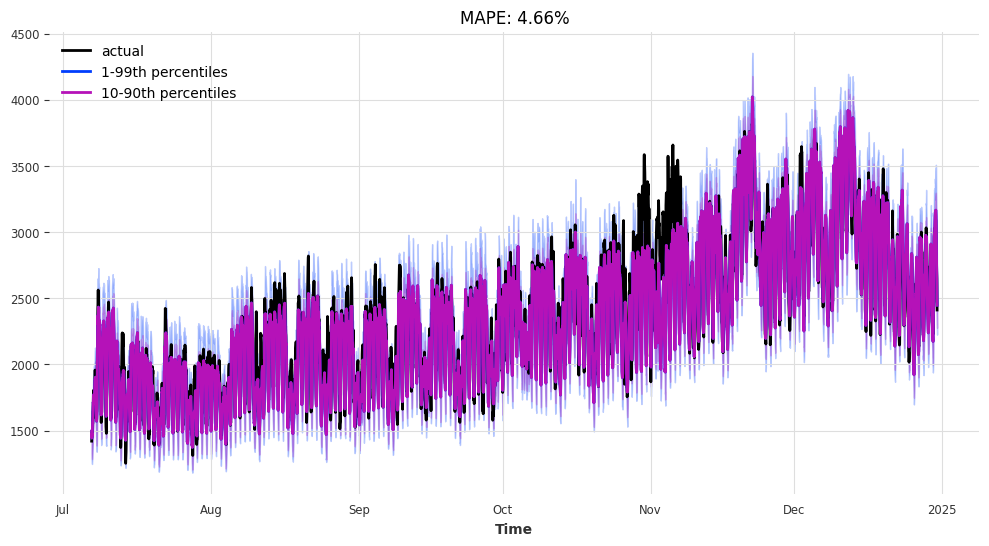

In [ ]:
# plot actual series


plt.figure(figsize=(12, 6))
test_series[: test_series.end_time()].plot(label="actual")
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
# plot prediction with quantile ranges
forecast_inv.plot(
    low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
)
forecast_inv.plot(low_quantile=low_q, high_quantile=high_q,
                  label=label_q_inner)

plt.title(f"MAPE: {mape(test_series, forecast_inv):.2f}%")
plt.legend()

# Short Forecasts

2024-07-21 23:00:00


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 4.30
MAE: 78.59
RMSE: 102.05
2024-10-13 23:00:00


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 4.19
MAE: 98.50
RMSE: 121.97
2024-10-27 23:00:00


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 14.18
MAE: 412.22
RMSE: 484.02
2024-12-01 23:00:00


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 3.90
MAE: 116.93
RMSE: 142.85
2024-12-22 23:00:00


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 4.58
MAE: 117.80
RMSE: 145.50


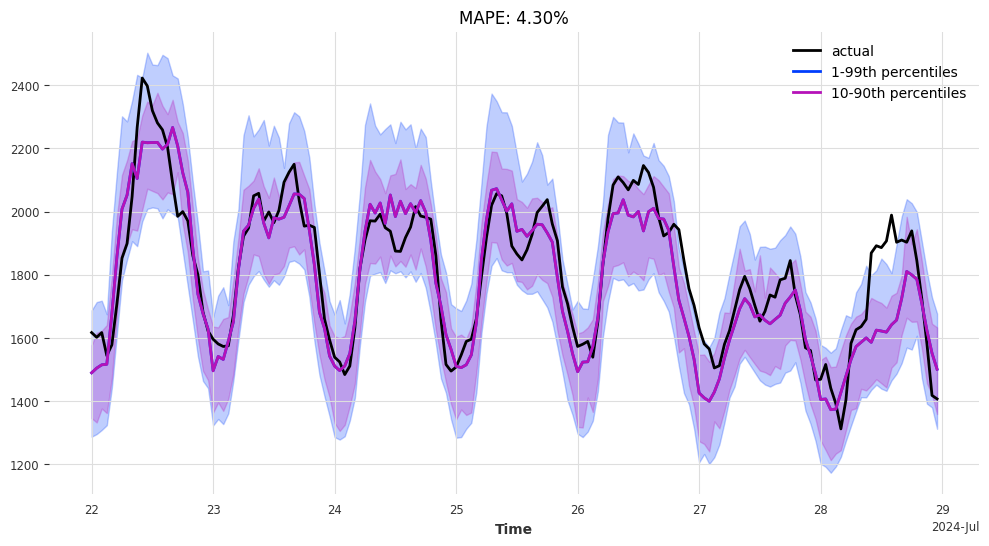

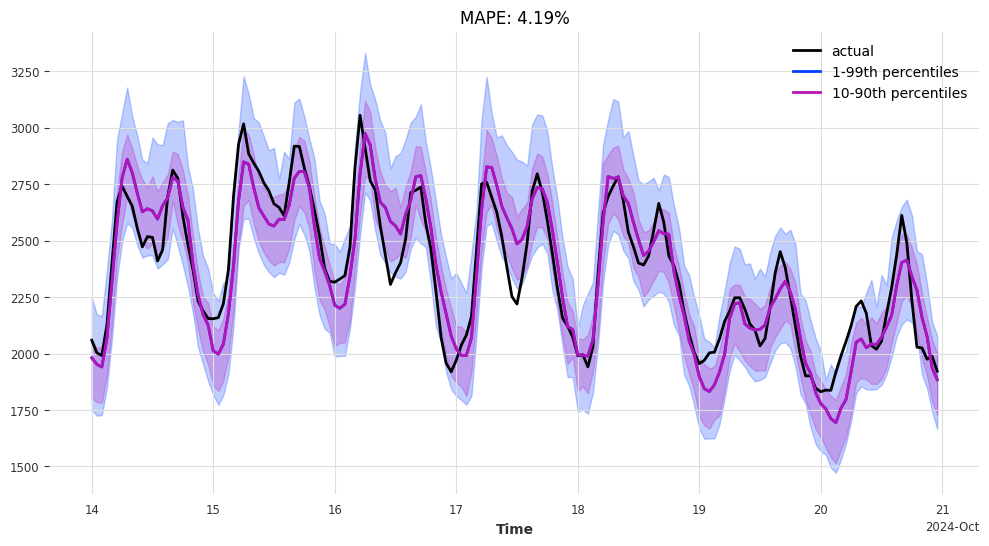

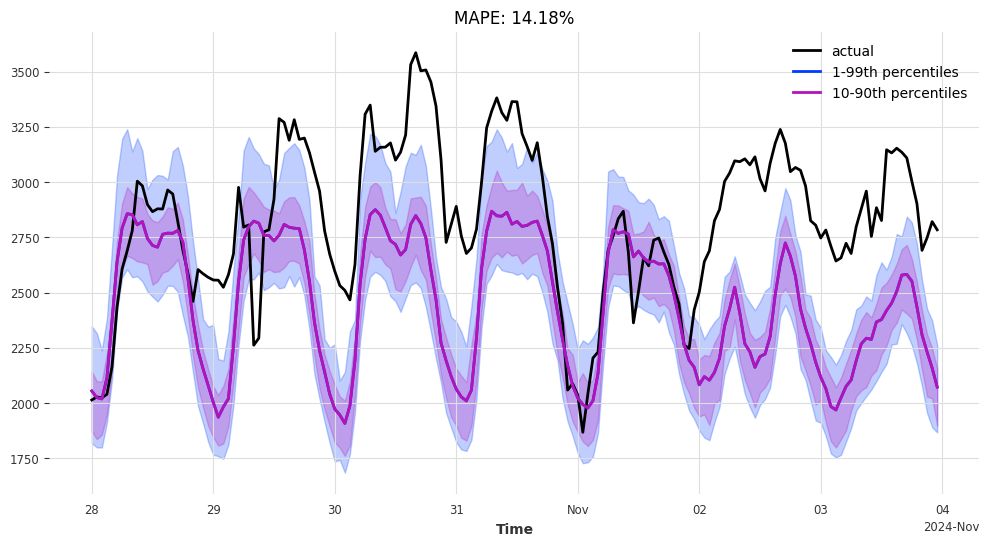

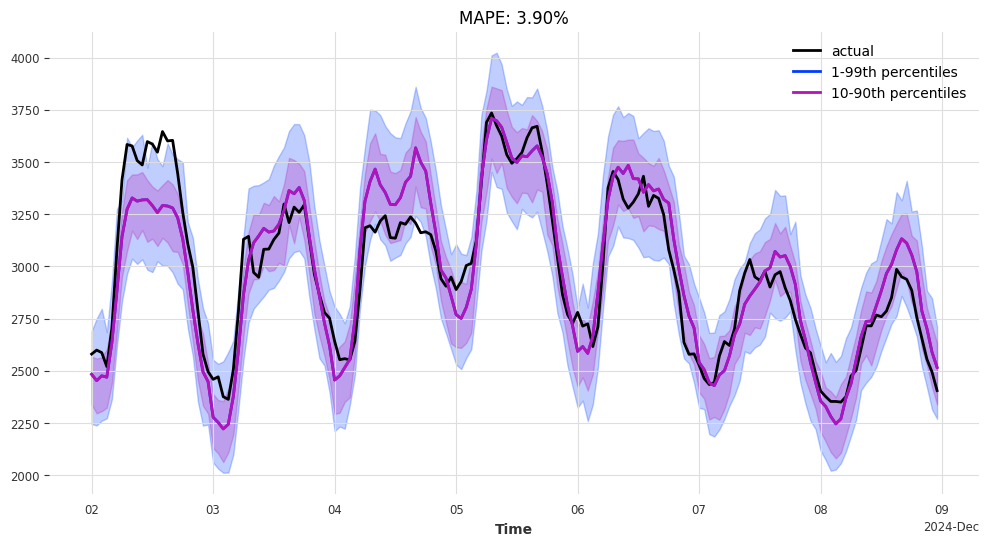

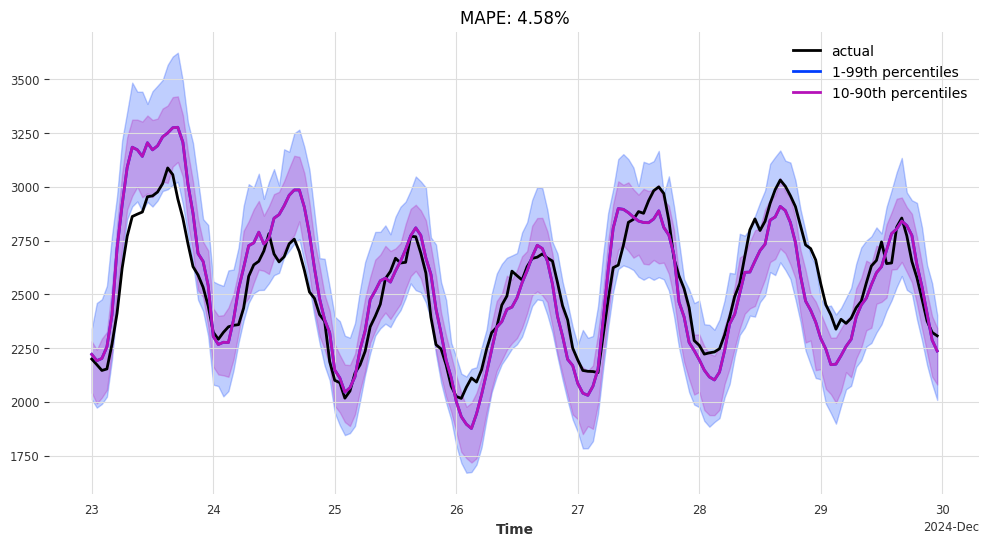

In [ ]:
# Specify the date for the forecast and number of days to forecast
forecast_dates = [
    pd.Timestamp("2024-07-21 23:00:00"),
    pd.Timestamp("2024-10-13 23:00:00"),
    pd.Timestamp("2024-10-27 23:00:00"),
    pd.Timestamp("2024-12-01 23:00:00"),
    pd.Timestamp("2024-12-22 23:00:00")
]
for i in range(len(forecast_dates)):
    forecast_date = forecast_dates[i]
    number_of_days = 7
    hours = number_of_days * 24
    # split the target series in the same way after forecast date
    the_series, discard = test_transformed.split_after(forecast_date)
    print(the_series.end_time())
    forecast = my_model.predict(
        n=hours,
        series=the_series,
        past_covariates=past_covariates_transformed,
        future_covariates=future_covariates_transformed,
        num_samples=100)
    # Inverse transform forecast and train data
    forecast_inv = transformer.inverse_transform(forecast)
    forecast_inv = forecast_inv
    start, end = forecast_inv.start_time(), forecast_inv.end_time()
    test_series = test.slice(start, end)

    # Calculate evaluation metrics
    tft_mape = mape(test_series, forecast_inv)  # MAPE
    tft_rmse = rmse(test_series, forecast_inv)  # RMSE
    tft_mse = mse(test_series, forecast_inv)  # MSE
    tft_r2 = r2_score(test_series, forecast_inv)  # R^2
    tft_smape = smape(test_series, forecast_inv)  # SMAPE
    tft_mae = mae(test_series, forecast_inv)  # MAE

    # Print results
    print(f"MAPE: {tft_mape:.2f}")
    print(f"MAE: {tft_mae:.2f}")
    print(f"RMSE: {tft_rmse:.2f}")

    # plot actual series

    plt.figure(figsize=(12, 6))
    test.slice(forecast_inv.start_time(),
               forecast_inv.end_time()).plot(label="actual")
    lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
    label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
    label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
    # plot prediction with quantile ranges
    forecast_inv.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    forecast_inv.plot(low_quantile=low_q,
                      high_quantile=high_q, label=label_q_inner)

    plt.title(f"MAPE: {mape(test_series, forecast_inv):.2f}%")
    plt.legend()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

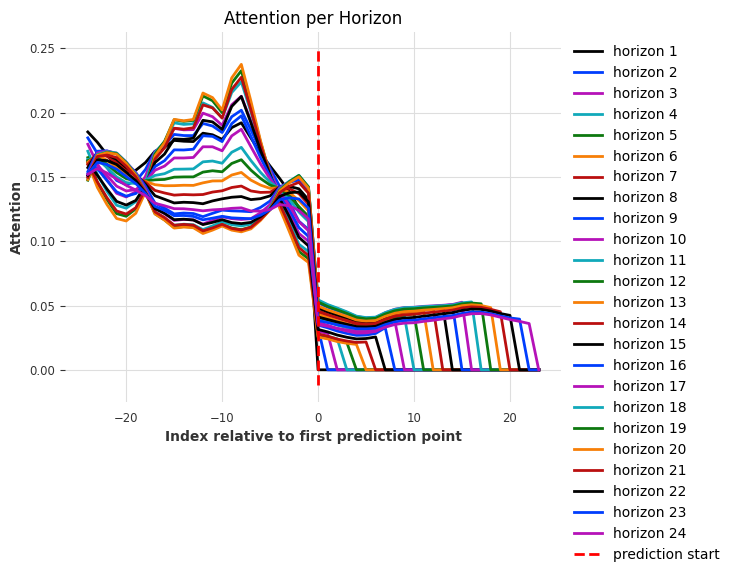

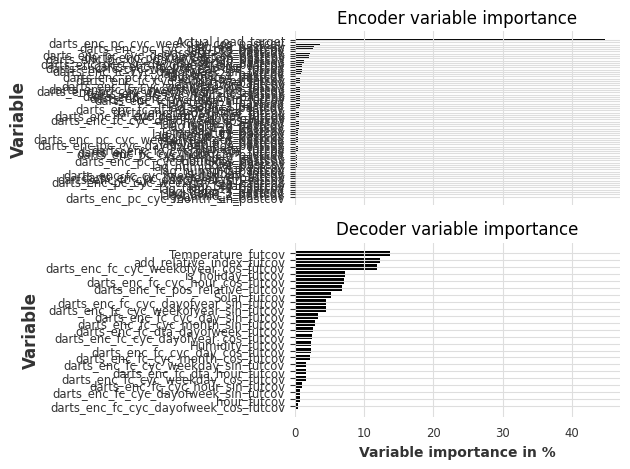

In [ ]:

# requires `background` if model was trained on multiple series
explainer = TFTExplainer(my_model)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)